<a href="https://colab.research.google.com/github/zi-bou/zi-bou/blob/main/Al4l_MONAI%2BPytorch_(V5).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Cardiac MRI Model Evolution Summary

| Version | Model                      | Augmentation                         | Loss        | Notes                                                    | Train Acc | Val Acc |
|---------|----------------------------|--------------------------------------|-------------|----------------------------------------------------------|-----------|---------|
| V1      | ResNet18                   | None                                 | CrossEntropy| Baseline model                                            | 38%       | 30%     |
| V2      | ResNet18                   | Basic 3D transforms                  | CrossEntropy| Added transforms to improve robustness                   | 43%       | 20%     |
| V3      | ResNet18 + Dropout         | Basic transforms                     | CrossEntropy| Dropout and oversampling added                           | 37%       | 30%     |
| V4      | ResNet18 + Dropout         | Class-specific (same for all)        | Focal Loss  | Introduced Focal Loss to handle class imbalance          | 43%       | 30%     |
| V5      | DenseNet121 + Dropout      | Class-specific (same for all)        | Focal Loss  | Switched to DenseNet121, achieved better generalization  | 37.5%     | 35%     |


In [ ]:
# ✅ Step 0: Uninstall conflicting versions completely
!pip uninstall -y numpy numba tensorflow thinc

#Reinstall safe NumPy + MONAI + friends
!pip install numpy==1.23.5
!pip install monai nibabel matplotlib scikit-learn torch torchvision torchaudio -q

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: numba 0.60.0
Uninstalling numba-0.60.0:
  Successfully uninstalled numba-0.60.0
Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
Found existing installation: thinc 8.3.6
Uninstalling thinc-8.3.6:
  Successfully uninstalled thinc-8.3.6
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 77.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
shap 0.47.1 requires numba>=0.54, which is not installed.
umap-learn 0.5.7 requires numba>=0.51.2, which is not installed.
cuml-cu12 25.2.1 requires numba<0.61.0a0,>=0.59.1, which is not installed.
librosa 0.11.0 requires numba>=0.51.0, which is not installed.
dopamine-rl 4.1.2 requires tensorflow

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
shap 0.47.1 requires numba>=0.54, which is not installed.
umap-learn 0.5.7 requires numba>=0.51.2, which is not installed.
cuml-cu12 25.2.1 requires numba<0.61.0a0,>=0.59.1, which is not installed.
librosa 0.11.0 requires numba>=0.51.0, which is not installed.
dopamine-rl 4.1.2 requires tensorflow>=2.2.0, which is not installed.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, which is not installed.
pynndescent 0.5.13 requires numba>=0.51.2, which is not installed.
spacy 3.8.5 requires thinc<8.4.0,>=8.3.4, which is not installed.
cudf-cu12 25.2.1 requires numba<0.61.0a0,>=0.59.1, which is not installed.
dask-cuda 25.2.0 requires numba<0.61.0a0,>=0.59.1, which is not installed.


In [ ]:
!pip install monai nibabel matplotlib scikit-learn -q

In [ ]:
# ✅ Step 1: Mount Google Drive
# Mount Google Drive to access dataset stored in the user's drive.
from google.colab import drive
# This command will prompt a link and code to authorize access
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ✅ Step 2: Import required libraries
# numpy: numerical operations
# nibabel: reading .nii.gz medical images
# torch: PyTorch core library
# sklearn: metrics and preprocessing
# monai: medical deep learning models and transforms
# matplotlib: plotting learning curves and confusion matrices
import os
import numpy as np
import nibabel as nib
import torch
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from monai.networks.nets import resnet18, densenet121
from monai.transforms import Compose, RandFlip, RandRotate, RandGaussianNoise, RandZoom


📏 Target shape (H, W, D): 224, 224, 32
[DEBUG] Input shape to DenseNet: torch.Size([2, 2, 32, 224, 224])
[DEBUG] Shape after features: torch.Size([2, 1024, 1, 7, 7])
[DEBUG] After GAP: torch.Size([2, 1024, 1, 1, 1])
[DEBUG] After flatten: torch.Size([2, 1024])
[DEBUG] After classifier: torch.Size([2, 5])
[DEBUG] Input shape to DenseNet: torch.Size([2, 2, 32, 224, 224])
[DEBUG] Shape after features: torch.Size([2, 1024, 1, 7, 7])
[DEBUG] After GAP: torch.Size([2, 1024, 1, 1, 1])
[DEBUG] After flatten: torch.Size([2, 1024])
[DEBUG] After classifier: torch.Size([2, 5])
[DEBUG] Input shape to DenseNet: torch.Size([2, 2, 32, 224, 224])
[DEBUG] Shape after features: torch.Size([2, 1024, 1, 7, 7])
[DEBUG] After GAP: torch.Size([2, 1024, 1, 1, 1])
[DEBUG] After flatten: torch.Size([2, 1024])
[DEBUG] After classifier: torch.Size([2, 5])
[DEBUG] Input shape to DenseNet: torch.Size([2, 2, 32, 224, 224])
[DEBUG] Shape after features: torch.Size([2, 1024, 1, 7, 7])
[DEBUG] After GAP: torch.Size([2,

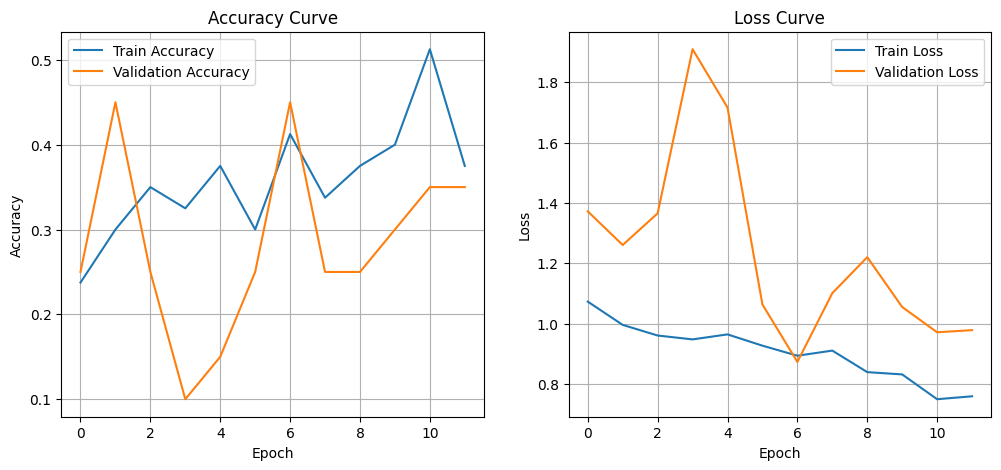

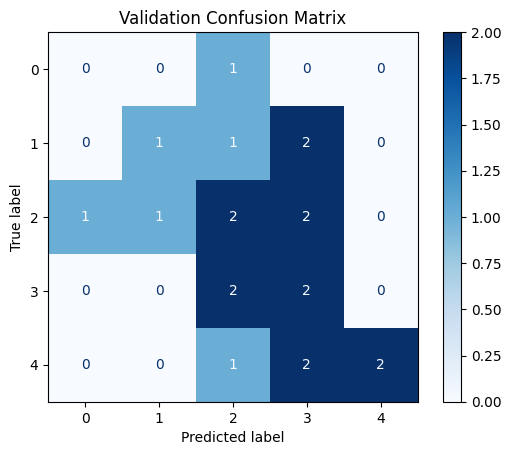

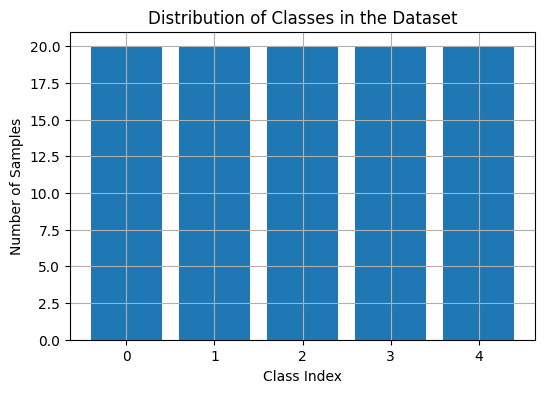

Best model saved at: /content/best_model_densenet121_v5.pth


In [ ]:
# ✅ Step 3: Estimate volume shape using 90th percentile
# Load a sample from each patient directory to extract its dimensions
# We'll use the 90th percentile of depth (D) to avoid memory overflow from very deep volumes
base_dir = '/content/drive/MyDrive/KAGGLE/Al4l/data/drive-download-20250107T191042Z-001/train'
depths, heights, widths = [], [], []

# Loop over all patient folders
for pid in os.listdir(base_dir):
    pdir = os.path.join(base_dir, pid)
    if not os.path.isdir(pdir):
        continue
    files = os.listdir(pdir)
    # We assume 'frame01' is always present and useful to extract volume shape
    for f in files:
        if 'frame01' in f and 'gt' not in f and f.endswith('.nii'):
            vol = nib.load(os.path.join(pdir, f)).get_fdata()
            h, w, d = vol.shape
            heights.append(h)
            widths.append(w)
            depths.append(d)

# Choose the final target shape used for resampling all volumes
# These dimensions will be used throughout model training
# 224x224 chosen for compatibility with pretrained CNNs and memory efficiency
# Depth is set to the 90th percentile of observed depths
target_height = 224
target_width = 224
target_depth = max(int(np.percentile(depths, 90)), 32) #If a volume’s depth (or height or width) is less than the target, the code pads it with zeros to reach the fixed size.
print(f"📏 Target shape (H, W, D): {target_height}, {target_width}, {target_depth}")

# ✅ Step 4: Define custom PyTorch Dataset for cardiac MRI
# This class loads systolic/diastolic volumes for each patient, preprocesses them, and returns their label

class CardiacDataset(Dataset): #This defines a custom dataset class that inherits from torch.utils.data.Dataset. It's how PyTorch knows how to load and access your data.
    def __init__(self, data_dir, target_shape, transform=None):
        self.data_dir = data_dir
        self.target_height, self.target_width, self.target_depth = target_shape
        self.patient_ids = [pid for pid in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, pid))]
        self.labels = []
        self.transform = transform

        # Load ground-truth label for each patient
        for pid in self.patient_ids:
            label_path = os.path.join(data_dir, pid, 'gt.txt')
            with open(label_path, 'r') as f:
                self.labels.append(f.read().strip())

        # Encode string labels into integers
        self.encoder = LabelEncoder()
        self.encoded_labels = self.encoder.fit_transform(self.labels)

    def __len__(self): # Returns the total number of patients (i.e., samples) in the dataset
        return len(self.patient_ids)

    def pad_or_crop(self, volume):
        # Pad or crop each dimension to match the target shape
        h, w, d = volume.shape
        pad_h = max(self.target_height - h, 0)
        pad_w = max(self.target_width - w, 0)
        pad_d = max(self.target_depth - d, 0)

        pad = (
            (pad_h//2, pad_h - pad_h//2),
            (pad_w//2, pad_w - pad_w//2),
            (pad_d//2, pad_d - pad_d//2)
        )

        # Apply padding and crop to fixed size
        volume = np.pad(volume, pad, mode='constant')
        volume = volume[:self.target_height, :self.target_width, :self.target_depth]
        return volume

    def __getitem__(self, idx): #  this is the heart of this custom PyTorch Dataset
        pid = self.patient_ids[idx]
        pdir = os.path.join(self.data_dir, pid)
        files = os.listdir(pdir)

        # Identify systolic and diastolic image file
        systolic, diastolic = None, None
        for f in files:
            if 'frame01' in f and 'gt' not in f and f.endswith('.nii'):
                systolic = f
            elif 'frame' in f and 'gt' not in f and 'frame01' not in f and f.endswith('.nii'):
                diastolic = f

        # Load and preprocess both volumes
        systolic_data = self.pad_or_crop(nib.load(os.path.join(pdir, systolic)).get_fdata())
        diastolic_data = self.pad_or_crop(nib.load(os.path.join(pdir, diastolic)).get_fdata())

        # Combine as 2-channel input
        combined = np.stack((systolic_data, diastolic_data), axis=0)
        combined = combined / np.max(combined) # Normalize volume intensities to [0, 1] to ensure consistent input scale


        # Convert to torch tensor and reorder axes to (C, D, H, W)
        # Convert NumPy array to a PyTorch tensor so it can be used with transforms and models.
        # As a general rule, keep data as NumPy during loading and preprocessing,
        # and convert to tensor only right before it's returned or passed into the model.
        combined = torch.tensor(combined, dtype=torch.float32)
        # Rearrange tensor axes:
        # From [C, H, W, D] → to [C, D, H, W] to match the input format expected by MONAI/PyTorch 3D models
        combined = combined.permute(0, 3, 1, 2)

        # Apply optional transforms
        if self.transform:
            combined = self.transform(combined)

        return combined, self.encoded_labels[idx]

# ✅ Step 5: Class-specific data augmentations (can be customized per class)
# For now, all classes use the same set of random transforms
base_transform = Compose([
    RandFlip(spatial_axis=0, prob=0.5),  # Random horizontal flip
    RandRotate(range_x=0.1, prob=0.5),   # Random rotation
    RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),  # Random zoom in/out
    RandGaussianNoise(prob=0.3, mean=0.0, std=0.05)  # Add noise
])

class CardiacDatasetWithClassAugment(CardiacDataset):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Apply same transform for each of the 5 classes
        self.class_transforms = {i: base_transform for i in range(5)}

    def __getitem__(self, idx):
        x, y = super().__getitem__(idx)
        transform = self.class_transforms.get(y, None)
        if transform:
            x = transform(x)
        return x, y

# ✅ Step 6: Dataset preparation, class balancing with sampling
# Create dataset and compute class weights
# Define target shape and create dataset
# Use weighted sampling to compensate for class imbalance
target_shape = (target_height, target_width, target_depth)
dataset = CardiacDatasetWithClassAugment(base_dir, target_shape)

y_all = [dataset.encoded_labels[i] for i in range(len(dataset))]
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_all), y=y_all)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to('cuda' if torch.cuda.is_available() else 'cpu')

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_indices = train_ds.indices if hasattr(train_ds, 'indices') else list(range(len(train_ds)))
train_labels = [dataset.encoded_labels[i] for i in train_indices]
train_weights = [class_weights[label] for label in train_labels]
sampler = WeightedRandomSampler(train_weights, num_samples=len(train_weights), replacement=True)

train_loader = DataLoader(train_ds, batch_size=2, sampler=sampler)
val_loader = DataLoader(val_ds, batch_size=2)
# 🔥 Free up any unused memory from earlier operations (like data loading)
torch.cuda.empty_cache()

# ✅ Step 7: Define MONAI DenseNet121 model with dropout
class DenseNet121WithDropout(nn.Module):
    def __init__(self):
        super().__init__()
        base_model = densenet121(spatial_dims=3, in_channels=2, out_channels=5)
        self.backbone = base_model
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(1024, 5)  # 🔧 Define custom classifier layer

    def forward(self, x):
        print("[DEBUG] Input shape to DenseNet:", x.shape) # Should be [B, C, D, H, W]
        # 🧠 This line passes the input through all convolutional layers of the DenseNet encoder
        x = self.backbone.features(x) # [B, C, H, W, D]
        print("[DEBUG] Shape after features:", x.shape) # Should still be 5D, just with fewer spatial dims and more channels
        # 🌀 Applies Global Average Pooling across the spatial dimensions (D, H, W)
        x = F.adaptive_avg_pool3d(x, (1, 1, 1)) # This reduces the shape from [B, C, D, H, W] → [B, C, 1, 1, 1]
        print("[DEBUG] After GAP:", x.shape)
        x = torch.flatten(x, 1) # Flatten into [B, C]
        print("[DEBUG] After flatten:", x.shape)
        x = self.dropout(x)
        x = self.classifier(x)  # → [B, 5]
        print("[DEBUG] After classifier:", x.shape)
        return x

model = DenseNet121WithDropout().to('cuda' if torch.cuda.is_available() else 'cpu')

# ✅ Step 8: Focal loss implementation to handle class imbalance
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        return focal_loss.mean() if self.reduction == 'mean' else focal_loss.sum()

criterion = FocalLoss(alpha=class_weights_tensor, gamma=2.0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# ✅ Step 9: Training loop with early stopping and model checkpointing
train_acc_list, val_acc_list = [], []
train_loss_list, val_loss_list = [], []
best_val_loss = float('inf')
early_stop_counter = 0

device = 'cuda' if torch.cuda.is_available() else 'cpu'

for epoch in range(1, 31):
    model.train()
    running_loss, correct = 0.0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        try:
          outputs = model(inputs)
        except Exception as e:
          print("[TRAIN ERROR] input shape:", inputs.shape)
          raise e
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()

    train_acc = correct / len(train_ds)
    train_acc_list.append(train_acc)
    train_loss_list.append(running_loss / len(train_loader))

    model.eval()
    val_correct, val_loss = 0, 0.0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_correct += (outputs.argmax(1) == labels).sum().item()
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_acc = val_correct / len(val_ds)
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss / len(val_loader))
    scheduler.step(val_loss)

    print(f"Epoch {epoch}: Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "/content/best_model_densenet121_v5.pth")
    else:
        early_stop_counter += 1
        if early_stop_counter >= 5:
            print("⏹️ Early stopping triggered.")
            break

# ✅ Step 10: Visualizations - learning curves and confusion matrix
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(val_acc_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

cm = confusion_matrix(all_labels, all_preds)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot(cmap='Blues')
plt.title("Validation Confusion Matrix")
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(y_all, bins=np.arange(6)-0.5, rwidth=0.8)
plt.title("Distribution of Classes in the Dataset")
plt.xlabel("Class Index")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.show()

print("Best model saved at: /content/best_model_densenet121_v5.pth")
